In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools

In [2]:
importlib.reload(ExperimentClass)
fluo_liquide = ExperimentClass.Experiment("20230427_cross_validation_fluo_liq", "Fluo_Liquide")
fluo_liquide.Time = fluo_liquide.Time - fluo_liquide.Time[0]
Acquisitions_df = fluo_liquide.annotations.copy()

fig_folder = fluo_liquide.path + "/Figures"
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)



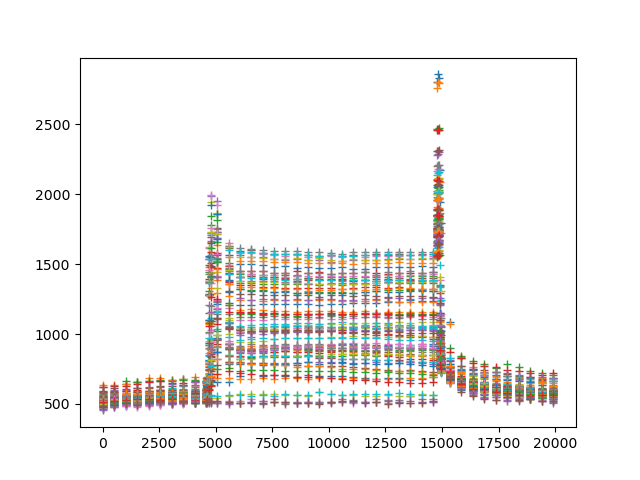

In [3]:
# visualize some acquisitions

fig, ax = plt.subplots()
for i in fluo_liquide.Data.keys():
    ax.plot(fluo_liquide.Time, fluo_liquide.Data[i],'+', label = i)


In [102]:
Acquisitions_df

,Record,Repeat,Acquisition,Direction,Actinic,Real_time
0,11,1,1,1,0,0.00
1,12,1,2,1,0,0.25
2,13,1,1,1,40,2.00
3,14,1,2,1,40,2.25
4,15,1,1,1,90,4.00
...,...,...,...,...,...,...
71,94,2,2,-1,90,78.25
72,95,2,1,-1,40,80.00
73,96,2,2,-1,40,80.25
74,97,2,1,-1,0,82.00


In [109]:
F_max = []
F_stat = []
F_0 = []
phi_stat = []
phi_0 = []
NPQ = []
ETR = []

for i, k in enumerate(Acquisitions_df.Record):
    F_0.append(np.mean(fluo_liquide.Data[f"E{k}"][2:11]))
    F_stat.append(np.mean(fluo_liquide.Data[f"E{k}"][25:33]))
    F_max.append(np.mean(fluo_liquide.Data[f"E{k}"][33:36]))
    phi_stat.append((F_max[i] - F_stat[i]) / F_max[i])
    phi_0.append((F_max[i] - F_0[i]) / F_max[i])
    NPQ.append((F_max[0] - F_max[i])/F_max[i])
    ETR.append(phi_stat[i] * Acquisitions_df.Actinic[i]) 
    

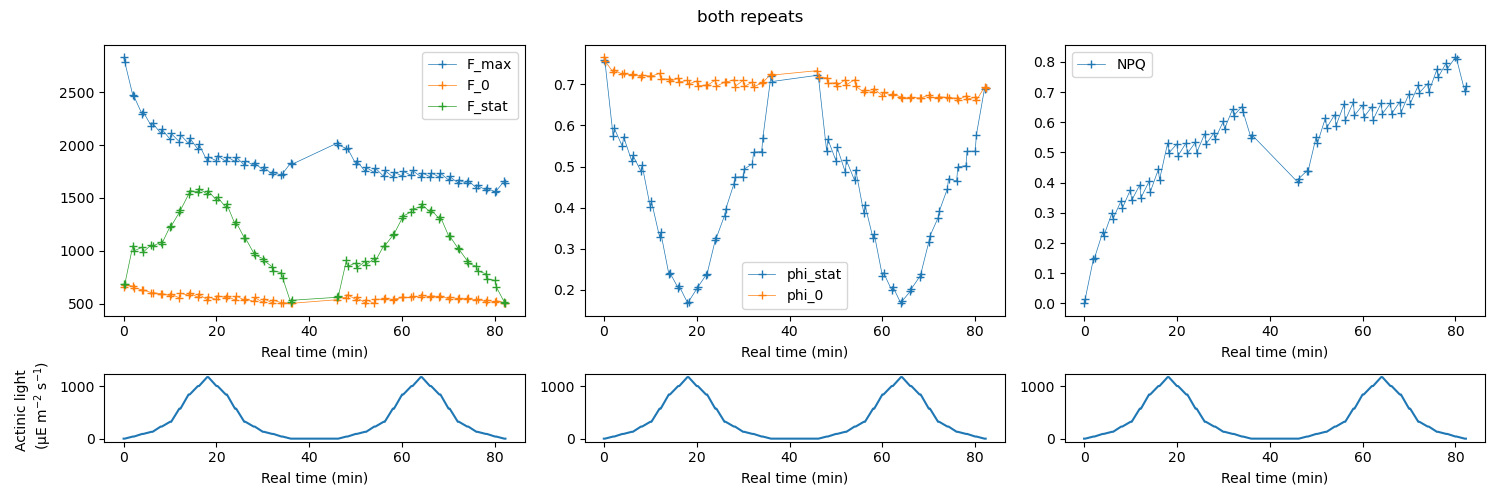

In [108]:
fig, ax = plt.subplots(2,3, figsize = (15,5), gridspec_kw={'height_ratios': [4, 1]})
fig.suptitle("both repeats")
ax[0,0].plot(Acquisitions_df.Real_time, F_max, '+-', linewidth = 0.5, label = 'F_max')
ax[0,0].plot(Acquisitions_df.Real_time, F_0, '+-', linewidth = 0.5, label = 'F_0')
ax[0,0].plot(Acquisitions_df.Real_time, F_stat, '+-', linewidth = 0.5, label = 'F_stat')
ax[0,0].legend()


ax[0,1].plot(Acquisitions_df.Real_time, phi_stat, '+-', linewidth = 0.5, label = 'phi_stat')
ax[0,1].plot(Acquisitions_df.Real_time, phi_0, '+-', linewidth = 0.5, label = 'phi_0')
ax[0,1].legend()


ax[0,2].plot(Acquisitions_df.Real_time, NPQ, '+-', linewidth = 0.5, label = 'NPQ')
ax[0,2].legend()


for i in [0, 1, 2]:
    ax[1,i].plot(Acquisitions_df.Real_time, Acquisitions_df.Actinic)
    
ax[1,0].set_ylabel("Actinic light \n (µE m$^{-2}$ s$^{-1}$)")
    


ax = ax.flatten()

[ax.set_xlabel("Real time (min)") for ax in ax]

fig.tight_layout()

fig.savefig(fig_folder + "/all_acq.png", dpi = 300)



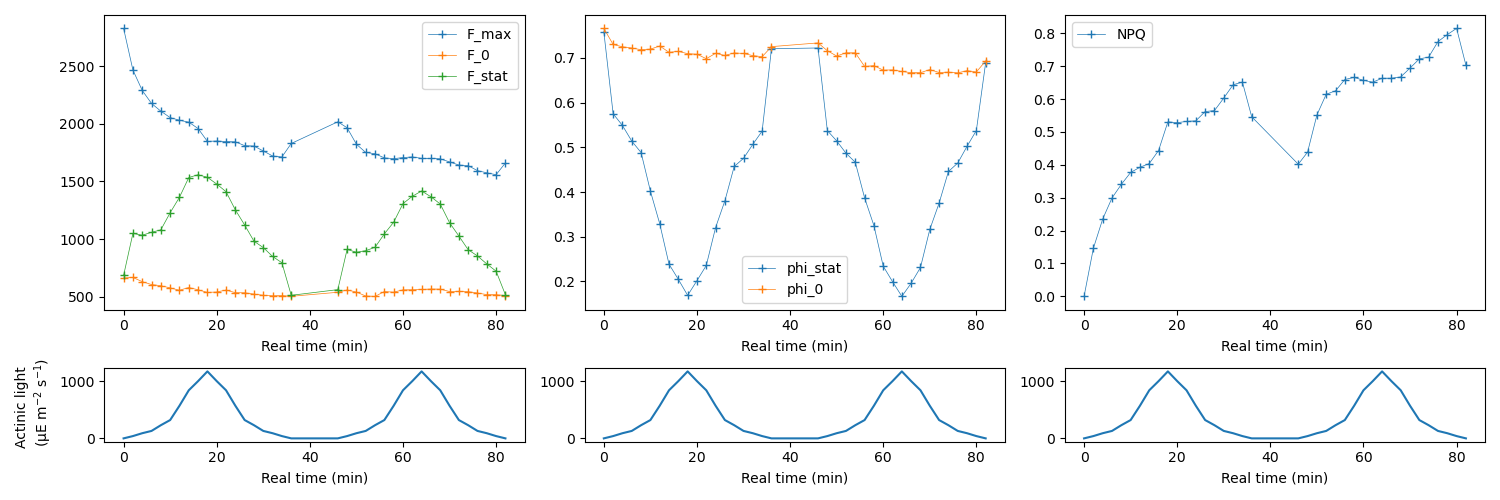

In [106]:
fig, ax = plt.subplots(2,3, figsize = (15,5), gridspec_kw={'height_ratios': [4, 1]})
ax[0,0].plot(Acquisitions_df.Real_time[::2], F_max[::2], '+-', linewidth = 0.5, label = 'F_max')
ax[0,0].plot(Acquisitions_df.Real_time[::2], F_0[::2], '+-', linewidth = 0.5, label = 'F_0')
ax[0,0].plot(Acquisitions_df.Real_time[::2], F_stat[::2], '+-', linewidth = 0.5, label = 'F_stat')
ax[0,0].legend()


ax[0,1].plot(Acquisitions_df.Real_time[::2], phi_stat[::2], '+-', linewidth = 0.5, label = 'phi_stat')
ax[0,1].plot(Acquisitions_df.Real_time[::2], phi_0[::2], '+-', linewidth = 0.5, label = 'phi_0')
ax[0,1].legend()


ax[0,2].plot(Acquisitions_df.Real_time[::2], NPQ[::2], '+-', linewidth = 0.5, label = 'NPQ')
ax[0,2].legend()

for i in [0, 1, 2]:
    ax[1,i].plot(Acquisitions_df.Real_time[::2], Acquisitions_df.Actinic[::2])
    
ax[1,0].set_ylabel("Actinic light \n (µE m$^{-2}$ s$^{-1}$)")

ax = ax.flatten()

[ax.set_xlabel("Real time (min)") for ax in ax]

fig.tight_layout()

fig.savefig(fig_folder + "/repeat1.png", dpi = 300)


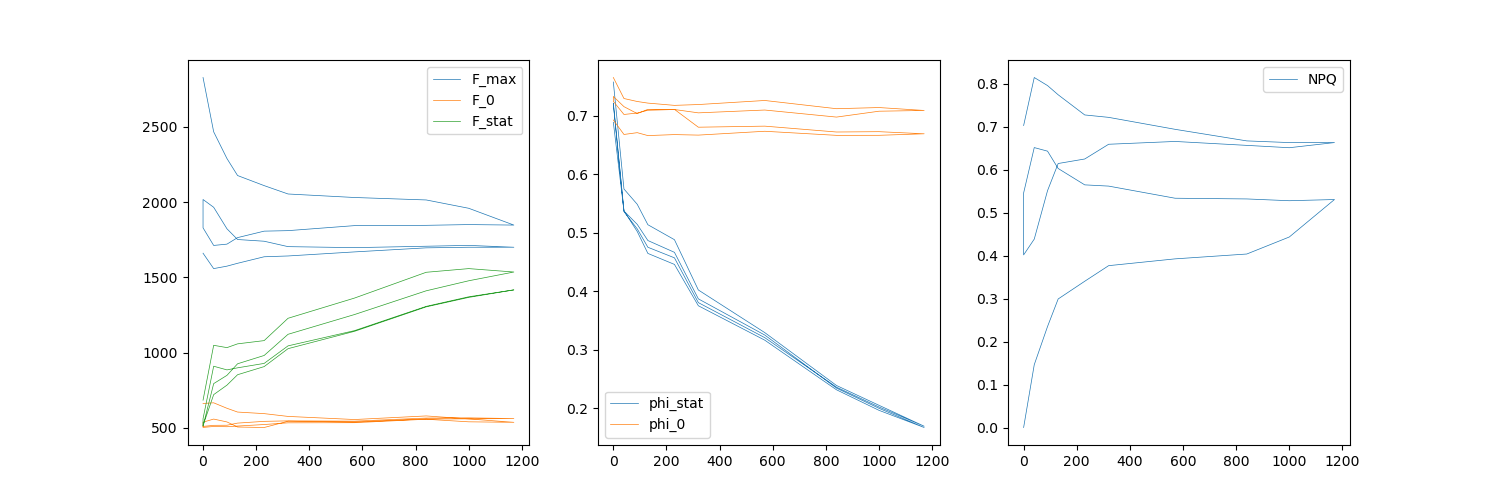

In [107]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].plot(Acquisitions_df.Actinic[::2], F_max[::2], '-', linewidth = 0.5, label = 'F_max')
ax[0].plot(Acquisitions_df.Actinic[::2], F_0[::2], '-', linewidth = 0.5, label = 'F_0')
ax[0].plot(Acquisitions_df.Actinic[::2], F_stat[::2], '-', linewidth = 0.5, label = 'F_stat')
ax[0].legend()  

ax[1].plot(Acquisitions_df.Actinic[::2], phi_stat[::2], '-', linewidth = 0.5, label = 'phi_stat')
ax[1].plot(Acquisitions_df.Actinic[::2], phi_0[::2], '-', linewidth = 0.5, label = 'phi_0')
ax[1].legend()

ax[2].plot(Acquisitions_df.Actinic[::2], NPQ[::2], '-', linewidth = 0.5, label = 'NPQ')
ax[2].legend()

fig.savefig(fig_folder + "/hist.png", dpi = 300)



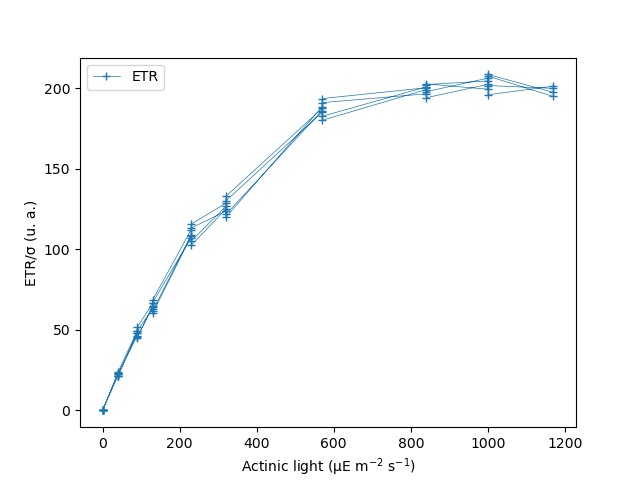

In [114]:
fig, ax = plt.subplots()
ax.plot(Acquisitions_df.Actinic, ETR, '+-', linewidth = 0.5, label = 'ETR')
ax.legend()  
ax.set_xlabel("Actinic light (µE m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("ETR/σ (u. a.)")

fig.savefig(fig_folder + "/ETR.png", dpi = 300)